<a href="https://colab.research.google.com/github/Marriyam/DataScience/blob/Marriyam/internship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
upload = files.upload()

Saving loan.csv to loan.csv


**importing data **

In [2]:
! pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 41 kB/s 
     |████████████████████████████████| 199 kB 66.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=1e150936d1bfb3c6a1ee039d9eac1c4b21954ed597f48046cc0d44e1d2db7dc3
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


**Importing Libraries**

In [3]:
#first load all the useful libraries
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession


In [4]:
#create the spark session
spark = SparkSession.builder.appName('Loan Dataset').getOrCreate()
spark

In [5]:
#Loading data from Colab
df = spark.read.csv('/content/loan.csv',header = True)
df.show()

+--------------------+------------+---------------------+--------------------+---------------------+-------------------------------------------+--------------------+---------------+-------------+---------------+-------------------------------------+--------------------+-------------------+
| loan_application_id|applicant_id|Months_loan_taken_for|             Purpose|Principal_loan_amount|EMI_rate_in_percentage_of_disposable_income|            Property|Has_coapplicant|Has_guarantor|Other_EMI_plans|Number_of_existing_loans_at_this_bank|        Loan_history|high_risk_applicant|
+--------------------+------------+---------------------+--------------------+---------------------+-------------------------------------------+--------------------+---------------+-------------+---------------+-------------------------------------+--------------------+-------------------+
|d68d975e-edad-11e...|     1469590|                    6|electronic equipment|              1169000|                           

**Printing Schemas**

In [6]:
df.printSchema()

root
 |-- loan_application_id: string (nullable = true)
 |-- applicant_id: string (nullable = true)
 |-- Months_loan_taken_for: string (nullable = true)
 |-- Purpose: string (nullable = true)
 |-- Principal_loan_amount: string (nullable = true)
 |-- EMI_rate_in_percentage_of_disposable_income: string (nullable = true)
 |-- Property: string (nullable = true)
 |-- Has_coapplicant: string (nullable = true)
 |-- Has_guarantor: string (nullable = true)
 |-- Other_EMI_plans: string (nullable = true)
 |-- Number_of_existing_loans_at_this_bank: string (nullable = true)
 |-- Loan_history: string (nullable = true)
 |-- high_risk_applicant: string (nullable = true)



In [7]:
df.count()

1000

In [8]:
#Describing the dataset with count, max min etc
for col in df.columns:
 df.describe([col]).show()


+-------+--------------------+
|summary| loan_application_id|
+-------+--------------------+
|  count|                1000|
|   mean|                null|
| stddev|                null|
|    min|d68d975e-edad-11e...|
|    max|d68fbdae-edad-11e...|
+-------+--------------------+

+-------+------------------+
|summary|      applicant_id|
+-------+------------------+
|  count|              1000|
|   mean|       1514763.121|
| stddev|228676.37334620522|
|    min|           1105364|
|    max|           1903505|
+-------+------------------+

+-------+---------------------+
|summary|Months_loan_taken_for|
+-------+---------------------+
|  count|                 1000|
|   mean|               20.903|
| stddev|   12.058814452756371|
|    min|                   10|
|    max|                    9|
+-------+---------------------+

+-------+------------+
|summary|     Purpose|
+-------+------------+
|  count|         988|
|   mean|        null|
| stddev|        null|
|    min|        FF&E|
|    max

Counting the Null Values

In [9]:
for col in df.columns:

 print(col, "\t", "with null values: ", df.filter(df[col].isNull()).count())

loan_application_id 	 with null values:  0
applicant_id 	 with null values:  0
Months_loan_taken_for 	 with null values:  0
Purpose 	 with null values:  12
Principal_loan_amount 	 with null values:  0
EMI_rate_in_percentage_of_disposable_income 	 with null values:  0
Property 	 with null values:  154
Has_coapplicant 	 with null values:  0
Has_guarantor 	 with null values:  0
Other_EMI_plans 	 with null values:  814
Number_of_existing_loans_at_this_bank 	 with null values:  0
Loan_history 	 with null values:  0
high_risk_applicant 	 with null values:  0


Counting Questioned Marked Missing Values

In [10]:
for col in df.columns:
 print(col, "\t", "with ‘?’ values: ", df.filter(df[col]=="?").count())


loan_application_id 	 with ‘?’ values:  0
applicant_id 	 with ‘?’ values:  0
Months_loan_taken_for 	 with ‘?’ values:  0
Purpose 	 with ‘?’ values:  0
Principal_loan_amount 	 with ‘?’ values:  0
EMI_rate_in_percentage_of_disposable_income 	 with ‘?’ values:  0
Property 	 with ‘?’ values:  0
Has_coapplicant 	 with ‘?’ values:  0
Has_guarantor 	 with ‘?’ values:  0
Other_EMI_plans 	 with ‘?’ values:  0
Number_of_existing_loans_at_this_bank 	 with ‘?’ values:  0
Loan_history 	 with ‘?’ values:  0
high_risk_applicant 	 with ‘?’ values:  0


Using Imputation to deal with missing values

In [11]:
from pyspark.sql.functions import avg

def mean_of_pyspark_columns(df2, numeric_cols, verbose=False):
    col_with_mean=[]
    for col in numeric_cols:
        mean_value = df2.select(avg(df2[col]))
        avg_col = mean_value.columns[0]
        res = mean_value.rdd.map(lambda row : row[avg_col]).collect()
        if (verbose==True): print(mean_value.columns[0], "\t", res[0])
        col_with_mean.append([col, res[0]])    
    return col_with_mean



In [12]:
from pyspark.sql.functions import when, lit

def fill_missing_with_mean(df, numeric_cols):
    col_with_mean = mean_of_pyspark_columns(df, numeric_cols) 
    
    for col, mean in col_with_mean:
        df = df.withColumn(col, when(df[col].isNull()==True, 
        lit(mean)).otherwise(df[col]))
        
    return df


numeric_cols=['loan_application_id','applicant_id','Months_loan_taken_for','Purpose','Principal_loan_amount','EMI_rate_in_percentage_of_disposable_income','Property','Has_coapplicant','Has_guarantor','Other_EMI_plans','Number_of_existing_loans_at_this_bank','Loan_history','high_risk_applicant']
df = fill_missing_with_mean(df, numeric_cols)

Replace string missing values with TBF

In [13]:
from pyspark.sql.types import StructType,StructField, StringType, IntegerType

df = df.fillna(value="TBF")
df.show()

+--------------------+------------+---------------------+--------------------+---------------------+-------------------------------------------+--------------------+---------------+-------------+---------------+-------------------------------------+--------------------+-------------------+
| loan_application_id|applicant_id|Months_loan_taken_for|             Purpose|Principal_loan_amount|EMI_rate_in_percentage_of_disposable_income|            Property|Has_coapplicant|Has_guarantor|Other_EMI_plans|Number_of_existing_loans_at_this_bank|        Loan_history|high_risk_applicant|
+--------------------+------------+---------------------+--------------------+---------------------+-------------------------------------------+--------------------+---------------+-------------+---------------+-------------------------------------+--------------------+-------------------+
|d68d975e-edad-11e...|     1469590|                    6|electronic equipment|              1169000|                           

**CountPlot**

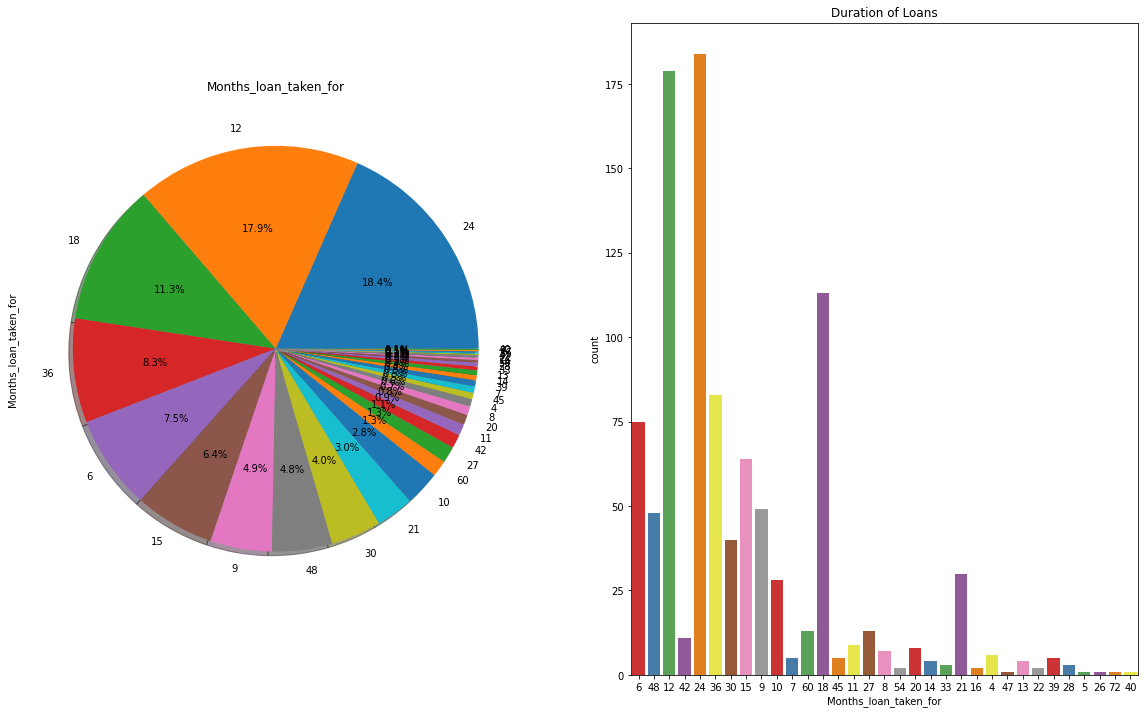

<Figure size 432x288 with 0 Axes>

In [14]:
# visualize frequency distribution of income variable

f,ax=plt.subplots(1,2,figsize=(20,12))
dat=df.toPandas()
ax[0] = dat['Months_loan_taken_for'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Months_loan_taken_for')


#f, ax = plt.subplots(figsize=(6, 8))
ax[1] = sns.countplot(x="Months_loan_taken_for", data=dat, palette="Set1")
ax[1].set_title("Duration of Loans")

plt.show()
plt.savefig('fig1.png')


**Count Plot2**

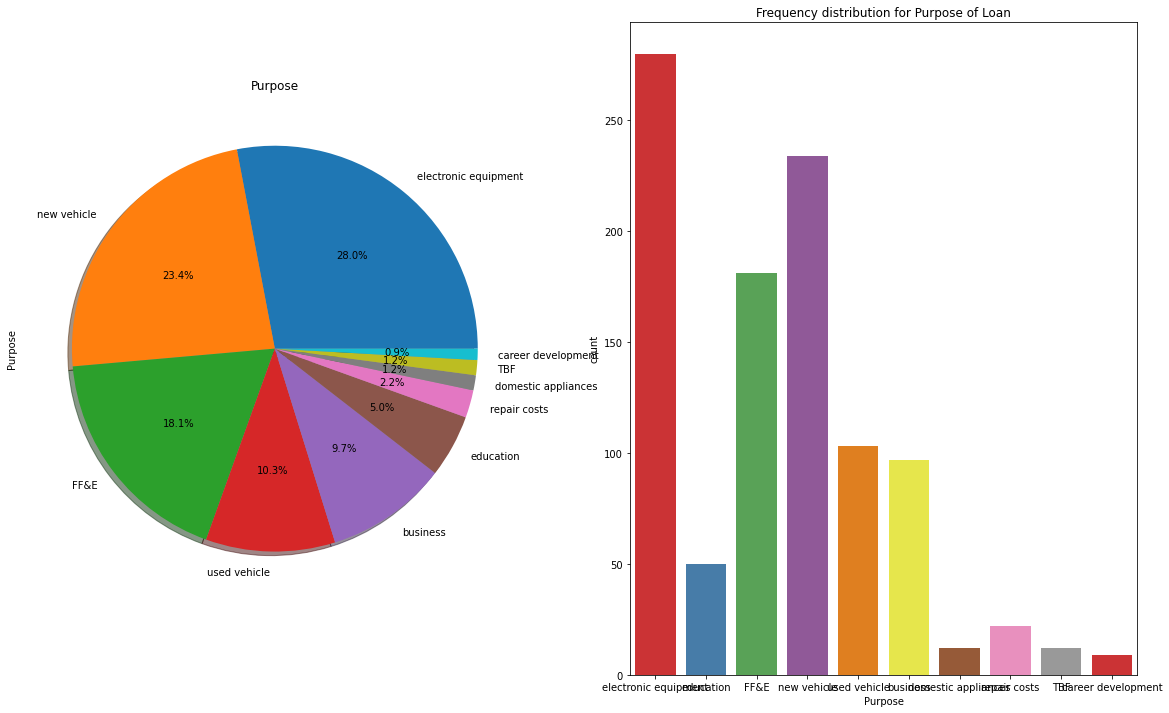

<Figure size 432x288 with 0 Axes>

In [15]:
# visualize frequency distribution of income variable

f,ax=plt.subplots(1,2,figsize=(20,12))
dat=df.toPandas()
ax[0] = dat['Purpose'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Purpose')


#f, ax = plt.subplots(figsize=(6, 8))
ax[1] = sns.countplot(x="Purpose", data=dat, palette="Set1")
ax[1].set_title("Frequency distribution for Purpose of Loan")

plt.show()
plt.savefig('fig2.png')


**Count Plot 3**

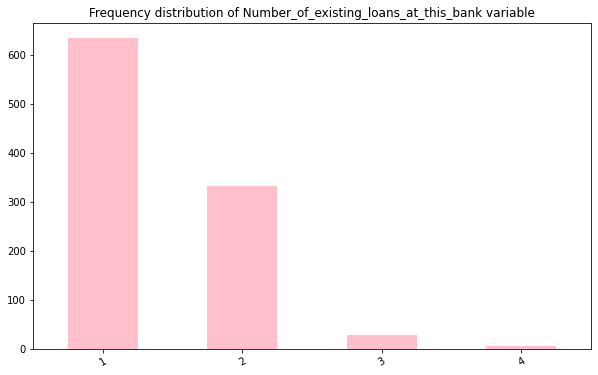

<Figure size 432x288 with 0 Axes>

In [16]:
f, ax = plt.subplots(figsize=(10, 6))
ax = dat.Number_of_existing_loans_at_this_bank.value_counts().plot(kind="bar", color="pink")
ax.set_title("Frequency distribution of Number_of_existing_loans_at_this_bank variable")
ax.set_xticklabels(dat.Number_of_existing_loans_at_this_bank.value_counts().index, rotation=30)
plt.show()
plt.savefig('fig3.png')

**Count Plot 4**

**Dist Plot**

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


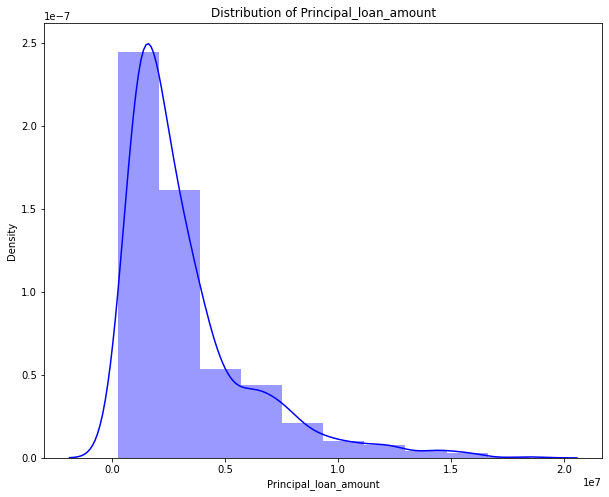

<Figure size 432x288 with 0 Axes>

In [17]:
f, ax = plt.subplots(figsize=(10,8))
x = dat['Principal_loan_amount']
ax = sns.distplot(x, bins=10, color='blue')
ax.set_title("Distribution of Principal_loan_amount")
plt.show()
plt.savefig('fig4.png')


**Distribution Plot**

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


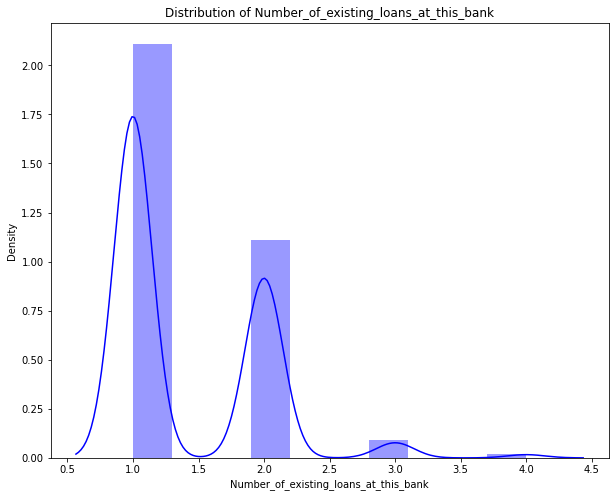

<Figure size 432x288 with 0 Axes>

In [18]:
f, ax = plt.subplots(figsize=(10,8))
x = dat['Number_of_existing_loans_at_this_bank']
ax = sns.distplot(x, bins=10, color='blue')
ax.set_title("Distribution of Number_of_existing_loans_at_this_bank")
plt.show()
plt.savefig('fig5.png')


**Dist Plot 3**

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


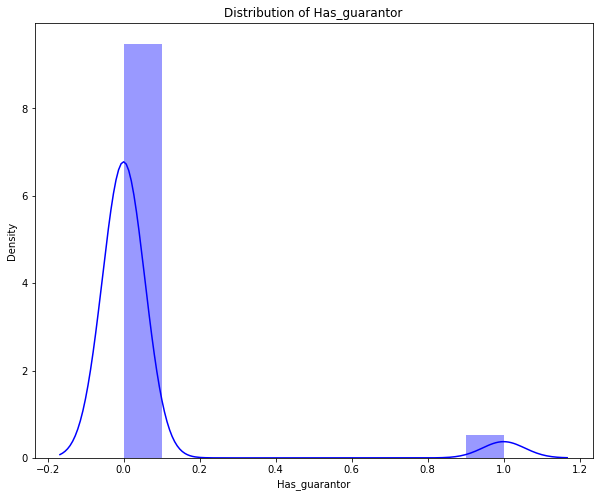

<Figure size 432x288 with 0 Axes>

In [19]:
f, ax = plt.subplots(figsize=(10,8))
x = dat['Has_guarantor']
ax = sns.distplot(x, bins=10, color='blue')
ax.set_title("Distribution of Has_guarantor")
plt.show()
plt.savefig('fig5.png')


**Dist Plot 4**

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


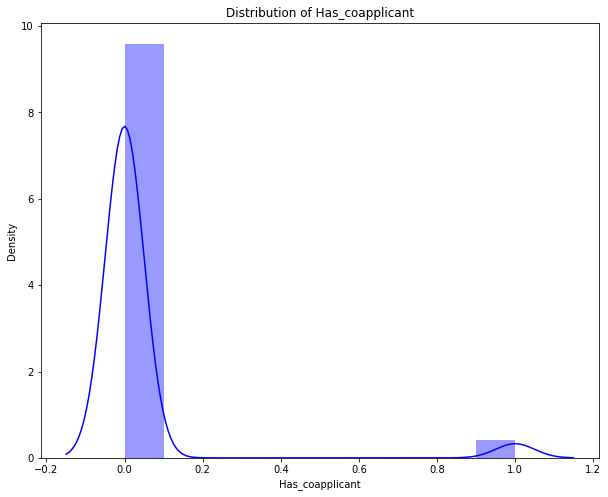

<Figure size 432x288 with 0 Axes>

In [20]:
f, ax = plt.subplots(figsize=(10,8))
x = dat['Has_coapplicant']
ax = sns.distplot(x, bins=10, color='blue')
ax.set_title("Distribution of Has_coapplicant")
plt.show()
plt.savefig('fig6.png')


In [21]:
df


DataFrame[loan_application_id: string, applicant_id: string, Months_loan_taken_for: string, Purpose: string, Principal_loan_amount: string, EMI_rate_in_percentage_of_disposable_income: string, Property: string, Has_coapplicant: string, Has_guarantor: string, Other_EMI_plans: string, Number_of_existing_loans_at_this_bank: string, Loan_history: string, high_risk_applicant: string]

**Casting To Integer**

In [22]:
from pyspark.sql.types import IntegerType
df = df.withColumn("Principal_loan_amount", df["Principal_loan_amount"].cast(IntegerType()))
df = df.withColumn("Months_loan_taken_for", df["Months_loan_taken_for"].cast(IntegerType()))

In [23]:
df

DataFrame[loan_application_id: string, applicant_id: string, Months_loan_taken_for: int, Purpose: string, Principal_loan_amount: int, EMI_rate_in_percentage_of_disposable_income: string, Property: string, Has_coapplicant: string, Has_guarantor: string, Other_EMI_plans: string, Number_of_existing_loans_at_this_bank: string, Loan_history: string, high_risk_applicant: string]

In [24]:
from pyspark.sql.functions import *
df.stat.corr('Principal_loan_amount', 'Months_loan_taken_for')

0.6249841983009838

In [27]:
from pyspark.sql.types import IntegerType
df = df.withColumn("Has_coapplicant", df["Has_coapplicant"].cast(IntegerType()))
df = df.withColumn("Has_guarantor", df["Has_guarantor"].cast(IntegerType()))

**Finding Correlation Between 2 cols**

In [28]:
from pyspark.sql.functions import *
df.stat.corr('Has_guarantor', 'Has_coapplicant')

-0.048426170628608586

In [29]:
from pyspark.sql.types import IntegerType
df = df.withColumn("Principal_loan_amount", df["Principal_loan_amount"].cast(IntegerType()))
df = df.withColumn("Number_of_existing_loans_at_this_bank", df["Number_of_existing_loans_at_this_bank"].cast(IntegerType()))

In [30]:
from pyspark.sql.functions import *
df.stat.corr('Principal_loan_amount', 'Number_of_existing_loans_at_this_bank')

0.02079455174896593